In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [33]:
import pickle
mv = pd.read_csv('./data/movielens_DBPR_cornac_Iter_fold0_seed_0.csv', header=None)
with open('./data/movielens_item_id2title.pkl', 'rb') as f:
    n2t = pickle.load(f)

In [34]:
X = mv.to_numpy()
u_nb,c_nb = X.shape

In [35]:
Y = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))

In [40]:
import numpy as np
Z = (Y - np.expand_dims(Y.min(axis=1),axis=1))/np.expand_dims((Y.max(axis=1)-Y.min(axis=1)),axis=1)

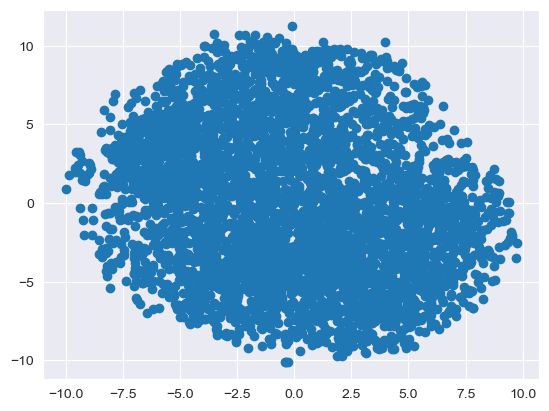

In [46]:
import numpy as np
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=300).fit_transform(Z)
plt.scatter(X_embedded[:,0],X_embedded[:,1])

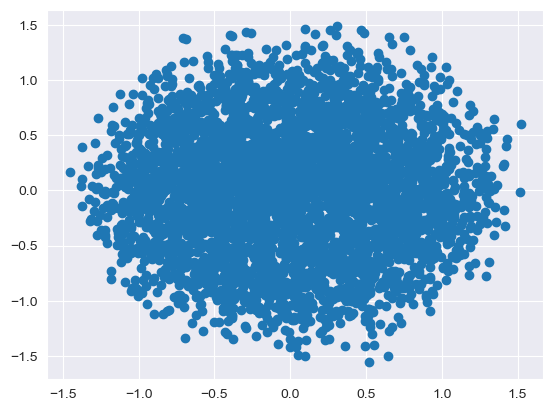

In [56]:
from sklearn import manifold

md_scaling = manifold.MDS(
    n_components=2,
    max_iter=50,
    n_init=4,
    random_state=0,
    normalized_stress=False,
)
S_scaling = md_scaling.fit_transform(Z)
plt.scatter(S_scaling[:,0],S_scaling[:,1])

In [ ]:
Var.argsort()

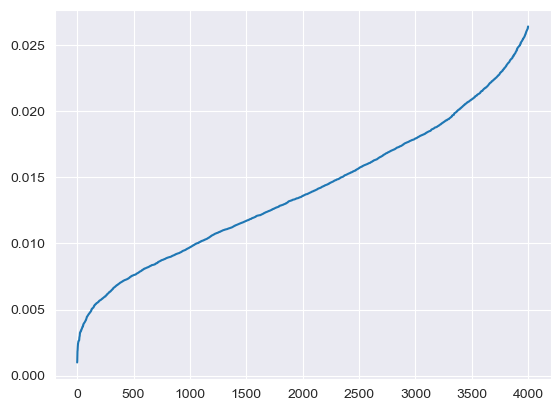

In [138]:
plt.plot(np.arange(len(s[:4000])), Var[s[:4000]])

In [156]:
from matplotlib import pyplot as plt
#Y_ind = np.argsort(np.median(Y[s[:4000]],axis=1))
Y_ind = np.argsort(Y[s[:4000]][:,0])
Y_ordered = Y[s[:4000]][Y_ind]
Y_ind

array([3225, 3761, 1404, ..., 2863,  195,  786])

In [166]:
import numpy as np
from numba import njit

@njit
def compute_dominance(Y):
    U, D = Y.shape
    dominance_counts = np.zeros(U, dtype=np.int32)
    for i in range(U):
        for j in range(U):
            if i != j:
                better_or_eq = True
                strictly_better = False
                for k in range(D):
                    if Y[i, k] < Y[j, k]:
                        better_or_eq = False
                        break
                    if Y[i, k] > Y[j, k]:
                        strictly_better = True
                if better_or_eq and strictly_better:
                    dominance_counts[i] += 1
    return dominance_counts

dominance_counts = compute_dominance(Y)
sorted_indices = np.argsort(-dominance_counts)
Y_sorted = Y[sorted_indices]


In [217]:
sorted_indices_cols = np.argsort(Y.mean(axis=0))
Y_sorted_cols = Y_sorted[:, sorted_indices_cols]

In [294]:
ind = np.argsort(Y_sorted_cols.var(axis=1))[:4000]

In [268]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

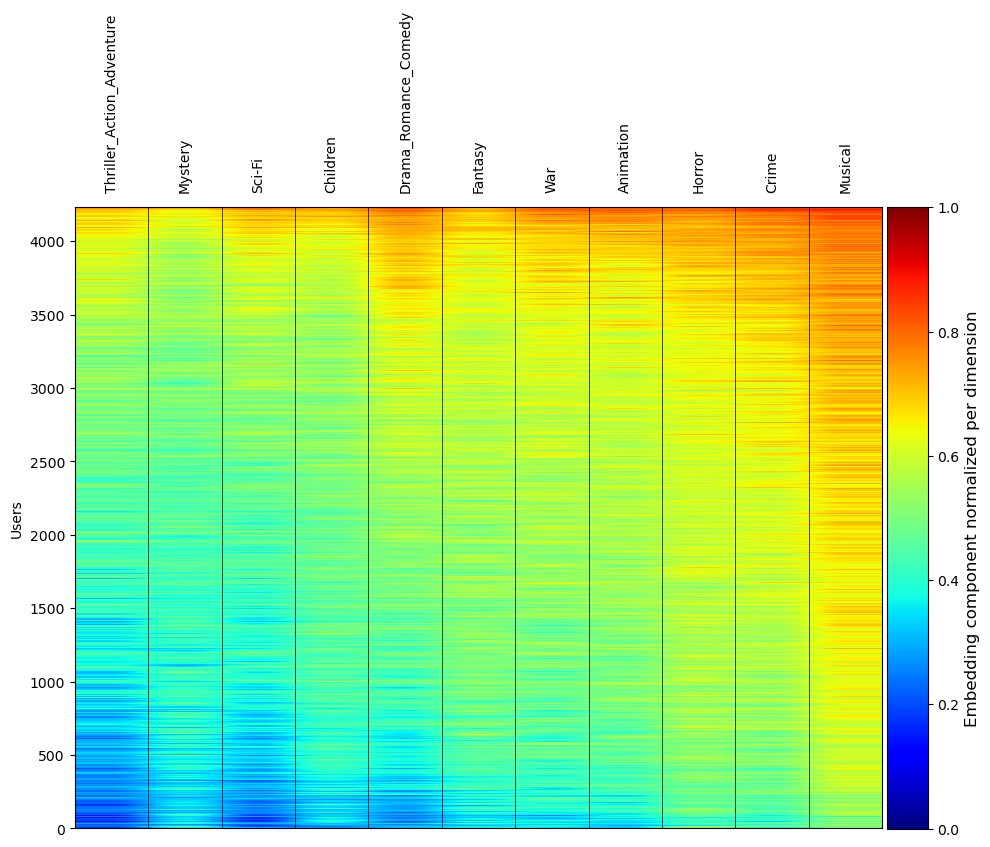

In [351]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(10, 10))
A, B = Y_sorted_cols.shape
extent = (0, B * 500, 0, A)

im = ax.imshow(Y_sorted_cols, extent=extent, cmap='jet')

for i in range(B + 1):
    x = i * 500
    ax.axvline(x, color='black', linewidth=0.5)

for i in range(B):
    x_center = (i + 0.5) * 500
    # Place labels slightly above the top (y = A), e.g., y = A + 0.3
    ax.text(x_center, A + 100, f"{col_names[sorted_indices_cols[i]]}",
            ha='center', va='bottom', rotation=90)
ax.set_xticks([])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # "5%" of the main axes width
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Embedding component normalized per dimension", fontsize=12)
ax.set_ylabel('Users')
fig.tight_layout()
plt.show()
fig.savefig('../../figs/movielens_emb_grad.pdf')


In [331]:
fig.savefig('../../figs/movielens_emb_grad.pdf')

In [6]:
import json
from CAT import utils
from CAT import dataset
from importlib import reload
reload(dataset)
dataset_name = "movielens"
i_fold =0
concept_map = json.load(open(f'../datasets/{dataset_name}/concept_map.json', 'r'))
concept_map = {int(k): [int(x) for x in v] for k, v in concept_map.items()}
metadata = json.load(open(f'../datasets/{dataset_name}/metadata.json', 'r'))
concept_array, concept_lens=utils.preprocess_concept_map(concept_map)

# read datasets
train_quadruplets = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_train_quadruples_vert_{i_fold}.csv',
                             encoding='utf-8').to_records(index=False,
                                                          column_dtypes={'student_id': int, 'item_id': int,
                                                                         "correct": float,"dimension_id":int})
valid_quadruplets = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_valid_quadruples_vert_{i_fold}.csv',
                             encoding='utf-8').to_records(index=False,
                                                          column_dtypes={'student_id': int, 'item_id': int,
                                                                         "correct": float,"dimension_id":int})
test_quadruplets = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_test_quadruples_vert_{i_fold}.csv',
                            encoding='utf-8').to_records(index=False,
                                                         column_dtypes={'student_id': int, 'item_id': int,
                                                                        "correct": float,"dimension_id":int})

train_data = dataset.LoaderDataset(train_quadruplets, concept_map, metadata)
valid_data = dataset.LoaderDataset(valid_quadruplets, concept_map, metadata)
test_data = dataset.LoaderDataset(test_quadruplets, concept_map, metadata)

In [32]:
train_data.n_logs

934785

In [39]:
print(train_data.raw_data_array[:,2])

tensor([2., 2., 2.,  ..., 2., 2., 1.], device='cuda:0')


In [48]:
@njit
def compute_test(log_tensor):
    count =0
    for r in log_tensor :
        for j in r :
            if j!=0:
                count +=1
    print(count)
compute_test(train_data.log_tensor.cpu().numpy())

671741


In [53]:
import torch

tensor_data = torch.zeros((train_data.n_users, train_data.n_items), device=train_data.raw_data_array.device)
sid = train_data.raw_data_array[:, 0].long()
qid = train_data.raw_data_array[:, 1].long()
val = train_data.raw_data_array[:, 2]

tensor_data.index_put_((sid, qid), val, accumulate=False)

tensor([[2.0000, 2.0000, 2.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.5000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.5000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [54]:
compute_test(tensor_data.cpu().numpy())

671741


In [5]:
train_df = pd.read_csv(f'../datasets/2-preprocessed_data/{dataset_name}_train_quadruples_vert_{i_fold}.csv',
                             encoding='utf-8',).rename(index={0:'student_id',1: 'item_id',2:
                                                                         "correct",3:"dimension_id"})
M = np.zeros((metadata["num_user_id"],metadata["num_dimension_id"]))
for (user_id, dim_id), mean_correct in train_df.groupby(['student_id','dimension_id'])['correct'].mean().items() :
    M[int(user_id),int(dim_id)] = mean_correct

In [82]:
M

array([[1.80555556, 1.80357143, 1.8125    , ..., 1.75      , 0.        ,
        0.        ],
       [0.        , 0.        , 1.69166667, ..., 1.625     , 1.58333333,
        1.5       ],
       [2.        , 1.75      , 1.66666667, ..., 0.        , 1.5       ,
        1.625     ],
       ...,
       [1.75      , 1.58333333, 1.68910256, ..., 1.7       , 1.66666667,
        1.78571429],
       [1.64285714, 1.625     , 1.68534483, ..., 1.75      , 1.79545455,
        1.75      ],
       [1.5       , 1.6875    , 1.62824675, ..., 1.73611111, 1.8125    ,
        1.42307692]])

In [10]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from numba import njit
# Example toy data
np.random.seed(0)
X = mv.to_numpy()
u_nb,c_nb = X.shape
@njit
def compute_test(log_tensor):
    count =0
    for r in log_tensor :
        for j in r :
            if j!=0:
                count +=1
    return count

@njit
def compute_X_feat(X,n_logs,n_categories, n_users, log_tensor) :
    X_feat = np.zeros((n_logs, n_categories + 1), dtype=np.float64)
    y_feat = np.zeros((n_logs,1), dtype=np.float64)

    idx=0
    for i in range(n_users):
        emb = X[i]
        for q_id, resp in enumerate(log_tensor[i]):
            if resp !=0 :
                X_feat[idx,:n_categories] = emb
                X_feat[idx,n_categories] = q_id
                y_feat[idx] = resp
                idx+=1

    return X_feat, y_feat

X_train, y_train = compute_X_feat(X,compute_test(train_data.log_tensor.cpu().numpy()), train_data.n_categories, train_data.n_users, train_data.log_tensor.cpu().numpy())
X_test, y_test = compute_X_feat(X,compute_test(test_data.log_tensor.cpu().numpy()), test_data.n_categories, test_data.n_users, test_data.log_tensor.cpu().numpy())




reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
preds = reg.predict(X_test)
rmse = np.sqrt(np.mean(np.square(y_test.squeeze(1)- preds)))

print("Test rmse:", rmse)
print(np.mean(np.abs(y_test.squeeze(1)- preds)))

Test rmse: 0.22971795894403096
0.11564034460812027


In [11]:
importances = reg.feature_importances_
print("Feature importances:", importances)
most_important_index = torch.topk(torch.tensor(importances), k=10).indices
axis_names = {
    0: 'Animation',
    1: 'Children',
    2: 'Drama_Romance_Comedy',
    3: 'Musical',
    4: 'Fantasy',
    5: 'Sci-Fi',
    6: 'Thriller_Action_Adventure',
    7: 'War',
    8: 'Crime',
    9: 'Mystery',
    10: 'Horror',
    11: 'question_id',
}
for i,feat in enumerate(most_important_index.tolist()):
    print("Feature ",i," : ",axis_names[feat])


Feature importances: [0.0338564  0.033157   0.11637707 0.04101486 0.05154974 0.03228488
 0.0334037  0.0347821  0.03427776 0.03844022 0.03679057 0.51406569]


NameError: name 'torch' is not defined

In [13]:
@njit
def compute_X_feat(X,n_logs,n_categories, n_users, log_tensor) :
    X_feat = np.zeros((n_logs, n_categories + 1), dtype=np.float64)
    y_feat = np.zeros((n_logs,1), dtype=np.float64)

    idx=0
    for i in range(n_users):
        emb = X[i]
        for q_id, resp in enumerate(log_tensor[i]):
            if resp !=0 :
                X_feat[idx,:n_categories] = emb
                X_feat[idx,n_categories] = q_id
                y_feat[idx] = resp
                idx+=1

    return X_feat, y_feat

X_train, y_train = compute_X_feat(M,compute_test(train_data.log_tensor.cpu().numpy()), train_data.n_categories, train_data.n_users, train_data.log_tensor.cpu().numpy())
X_test, y_test = compute_X_feat(M,compute_test(test_data.log_tensor.cpu().numpy()), test_data.n_categories, test_data.n_users, test_data.log_tensor.cpu().numpy())


reg2 = DecisionTreeRegressor()
reg2.fit(X_train, y_train)
preds = reg2.predict(X_test)
rmse = np.sqrt(np.mean(np.square(y_test.squeeze(1)- preds)))

print("Test rmse:", rmse)
print(np.mean(np.abs(y_test.squeeze(1)- preds)))

Test rmse: 0.2309509617216235
0.11698613674101413


In [145]:
importances = reg2.feature_importances_
print("Feature importances:", importances)
most_important_index2 = torch.topk(torch.tensor(importances), k=10).indices
axis_names = {
    0: 'Animation',
    1: 'Children',
    2: 'Drama_Romance_Comedy',
    3: 'Musical',
    4: 'Fantasy',
    5: 'Sci-Fi',
    6: 'Thriller_Action_Adventure',
    7: 'War',
    8: 'Crime',
    9: 'Mystery',
    10: 'Horror',
    11: 'question_id',
}
for i,feat in enumerate(most_important_index2.tolist()):
    print("Feature ",i," : ",axis_names[feat])

Feature importances: [0.03283029 0.03555054 0.1709583  0.03250991 0.03266162 0.03982725
 0.05118884 0.03692859 0.03835058 0.03406822 0.0370093  0.45811657]
Feature  0  :  question_id
Feature  1  :  Drama_Romance_Comedy
Feature  2  :  Thriller_Action_Adventure
Feature  3  :  Sci-Fi
Feature  4  :  Crime
Feature  5  :  Horror
Feature  6  :  War
Feature  7  :  Children
Feature  8  :  Mystery
Feature  9  :  Animation


In [126]:
most_important_index.numpy()

array([11,  2,  6])

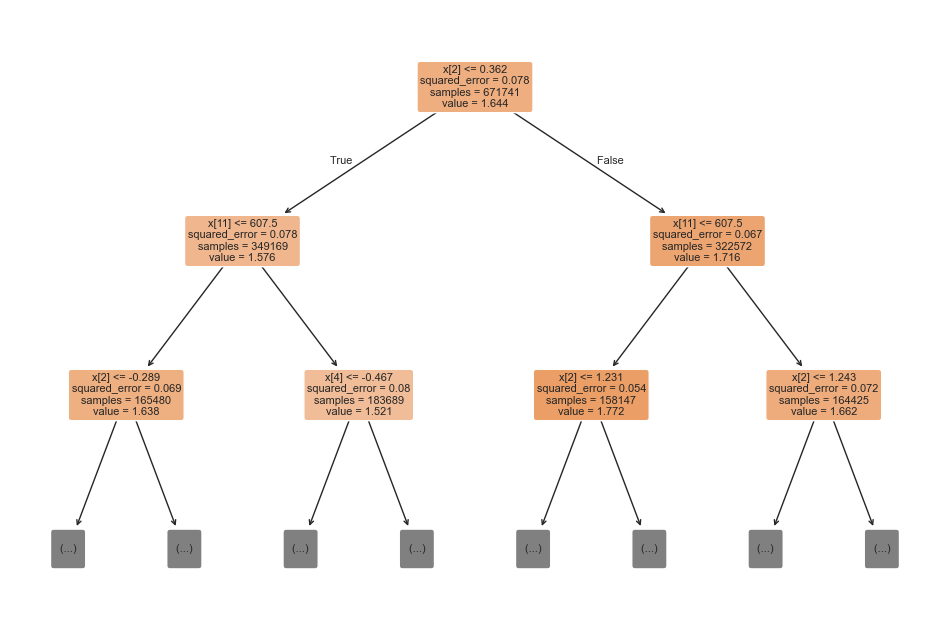

In [149]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Adjust size as needed
plot_tree(
    reg,
    max_depth=2,
    filled=True,
    rounded=True
)
plt.show()

In [342]:
import torch
torch.topk(torch.var(torch.tensor(X),axis=1), k=5, largest=True)

torch.return_types.topk(
values=tensor([1.8410, 1.2131, 1.0744, 1.0582, 0.9899], dtype=torch.float64),
indices=tensor([2827, 1531, 3353, 2726, 2406]))

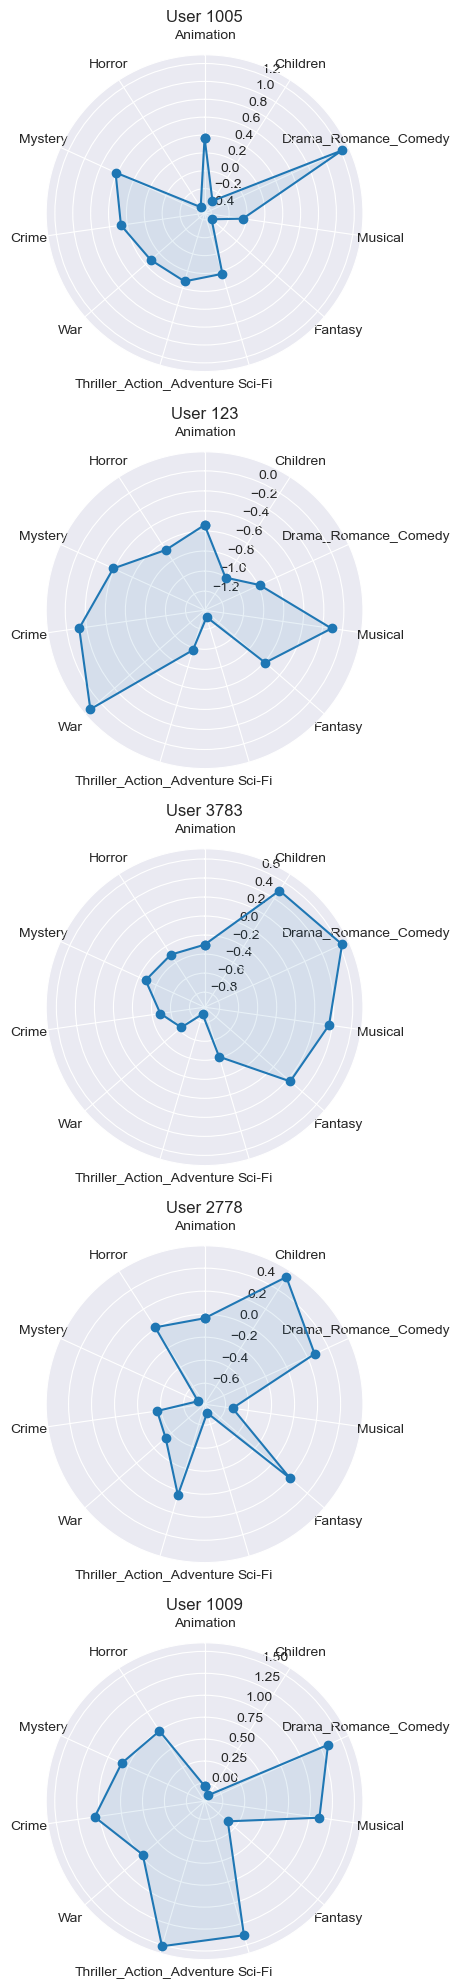

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def plot_radar(user_index, user_tensor, axis_dict,ax):

    user_embedding = user_tensor[user_index, :]
    categories = [axis_dict[i] for i in sorted(axis_dict)]
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # close the circle
    values = np.concatenate((user_embedding, [user_embedding[0]]))


    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.plot(angles, values, marker='o', label=f'User {user_index}')
    ax.fill(angles, values, alpha=0.1)

axis_names = {
    0: 'Animation',
    1: 'Children',
    2: 'Drama_Romance_Comedy',
    3: 'Musical',
    4: 'Fantasy',
    5: 'Sci-Fi',
    6: 'Thriller_Action_Adventure',
    7: 'War',
    8: 'Crime',
    9: 'Mystery',
    10: 'Horror'
}

fig, axs = plt.subplots(5,1,figsize=(10,20), subplot_kw={'polar': True})
for i,u in enumerate([1005, 123, 3783, 2778,1009] ):
    plot_radar(user_index=u, user_tensor=X, axis_dict=axis_names,ax=axs[i])
    axs[i].set_title(f'User {u}')

plt.tight_layout()
plt.show()


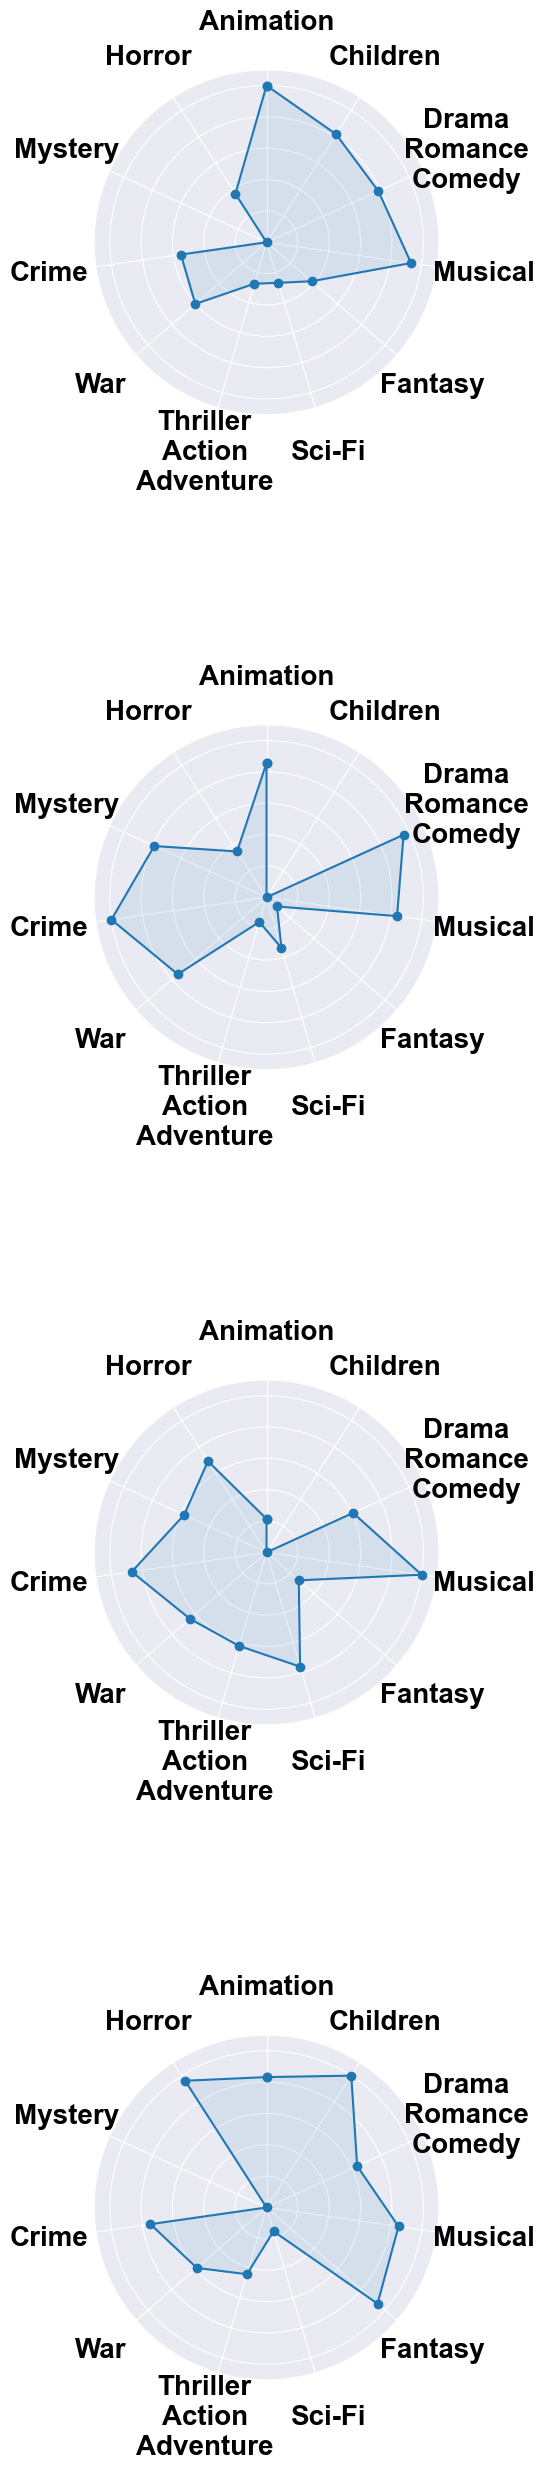

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.patches import Patch

def plot_radar(user_index, user_tensor, axis_dict, ax):
    # Extract the user's embedding vector
    user_embedding = user_tensor[user_index, :]

    # Define categories based on the axis_dict
    categories = [axis_dict[i] for i in sorted(axis_dict)]
    N = len(categories)

    # Compute angles for each category
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    # Append the first value to close the radar plot
    values = np.concatenate((user_embedding, [user_embedding[0]]))
    values = (values-np.min(values))/(np.max(values)-np.min(values))
    # Configure the radar plot's orientation
    ax.set_theta_offset(np.pi / 2)  # Start the plot at the top
    ax.set_theta_direction(-1)      # Clockwise direction

    # Set the number of ticks and remove default labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([])  # Disable default labels

    # Plot the data
    ax.plot(angles, values, marker='o', label=f'User {user_index}')
    ax.fill(angles, values, alpha=0.1)

    # Determine the maximum value to set label distance
    max_val = max(values)
    label_radius = max_val * 1.1  # 20% further out; adjust as needed

    # Place the labels manually at the specified radius
    for angle, category in zip(angles, categories):
        ax.text(angle, label_radius+0.3, category,
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=20,  # Adjust font size as needed
                fontweight='bold',
                color='black')  # Adjust color as needed

    # Optional: Adjust the radial limit to ensure labels fit within the plot
    ax.set_ylim(0, label_radius )  # Extra space for labels
    ax.set_yticklabels([])  # Disable radial tick labels

# Define the axis names
axis_names = {
    0: 'Animation',
    1: 'Children',
    2: 'Drama\nRomance\nComedy',
    3: 'Musical',
    4: 'Fantasy',
    5: 'Sci-Fi',
    6: 'Thriller\nAction\nAdventure',
    7: 'War',
    8: 'Crime',
    9: 'Mystery',
    10: 'Horror'
}

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 30), subplot_kw={'polar': True})

# List of user indices to plot
user_indices = [128, 1005, 1009,2778]
users = user_indices

# Plot radar charts for each user
for i, u in enumerate(user_indices):
    plot_radar(user_index=u, user_tensor=Y, axis_dict=axis_names, ax=axs[i])

# Adjust subplot spacing
plt.subplots_adjust(hspace=0.9)

plt.show()
fig.savefig('../../figs/movielens_emb_profiles.svg')


In [28]:
import torch

for u in range(4):
    films = torch.topk(test_data.log_tensor[users[u], :],3)
    film_list = []
    genre_list = []
    for film in films.indices.tolist():
        film_list.append(n2t[film])
        genre_list.append([axis_names[x] for x in concept_map[film]])
    print("user "+str(u)+" top 3 favorite movies :" +str(film_list)+"; ratings : "+str(((films.values-1)*5).tolist()))
    print("associated dimension : "+str(genre_list))
import torch
filled = test_data.log_tensor.clone()
filled[filled==0]=5
for u in range(4):
    films = torch.topk(filled[users[u], :],3, largest=False)
    film_list = []
    genre_list = []
    for film in films.indices.tolist():
        film_list.append(n2t[film])
        genre_list.append([axis_names[x] for x in concept_map[film]])
    print("user "+str(u)+" top hated movies :" +str(film_list) +"; ratings : "+str(((films.values-1)*5).tolist()))
    print("associated dimension : "+str(genre_list))

user 0 top 3 favorite movies :['Wizard of Oz, The (1939)', 'Beauty and the Beast (1991)', "Schindler's List (1993)"]; ratings : [5.0, 5.0, 5.0]
associated dimension : [['Children', 'Drama\nRomance\nComedy', 'Musical', 'Thriller\nAction\nAdventure'], ['Animation', 'Children', 'Musical'], ['Drama\nRomance\nComedy', 'War']]
user 1 top 3 favorite movies :['As Good As It Gets (1997)', 'GoodFellas (1990)', 'Star Wars: Episode V - The Empire Strikes Back (1980)']; ratings : [5.0, 5.0, 5.0]
associated dimension : [['Drama\nRomance\nComedy'], ['Crime', 'Drama\nRomance\nComedy'], ['Drama\nRomance\nComedy', 'Sci-Fi', 'Thriller\nAction\nAdventure', 'War']]
user 2 top 3 favorite movies :['True Lies (1994)', 'Sixth Sense, The (1999)', 'Back to the Future (1985)']; ratings : [5.0, 5.0, 5.0]
associated dimension : [['Drama\nRomance\nComedy', 'Thriller\nAction\nAdventure'], ['Thriller\nAction\nAdventure'], ['Drama\nRomance\nComedy', 'Sci-Fi']]
user 3 top 3 favorite movies :['Glory (1989)', 'Babe (1995)

In [44]:
test_data.raw_data

rec.array([(   0,    1, 2.  ,  0), (   0,    3, 1.75,  4),
           (   0,    6, 1.75,  0), ..., (4230, 2228, 1.75,  2),
           (4230, 2255, 1.  , 10), (4230, 2278, 1.75,  2)],
          dtype=[('student_id', '<i8'), ('item_id', '<i8'), ('correct', '<f8'), ('dimension_id', '<i8')])

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6,2)

for i in range(11):
    axs[i%6, i//6].hist(X[:,i], bins=30)

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(6,2)

for i in range(11):
    axs[i%6, i//6].hist(M[:,i], bins=30)

In [51]:
from sklearn.preprocessing import KBinsDiscretizer
nbb=2
enc = KBinsDiscretizer(n_bins=nbb, encode="ordinal", strategy='kmeans') #‘uniform’, ‘quantile’, ‘kmeans’
X_binned = np.array(enc.fit_transform(Z))

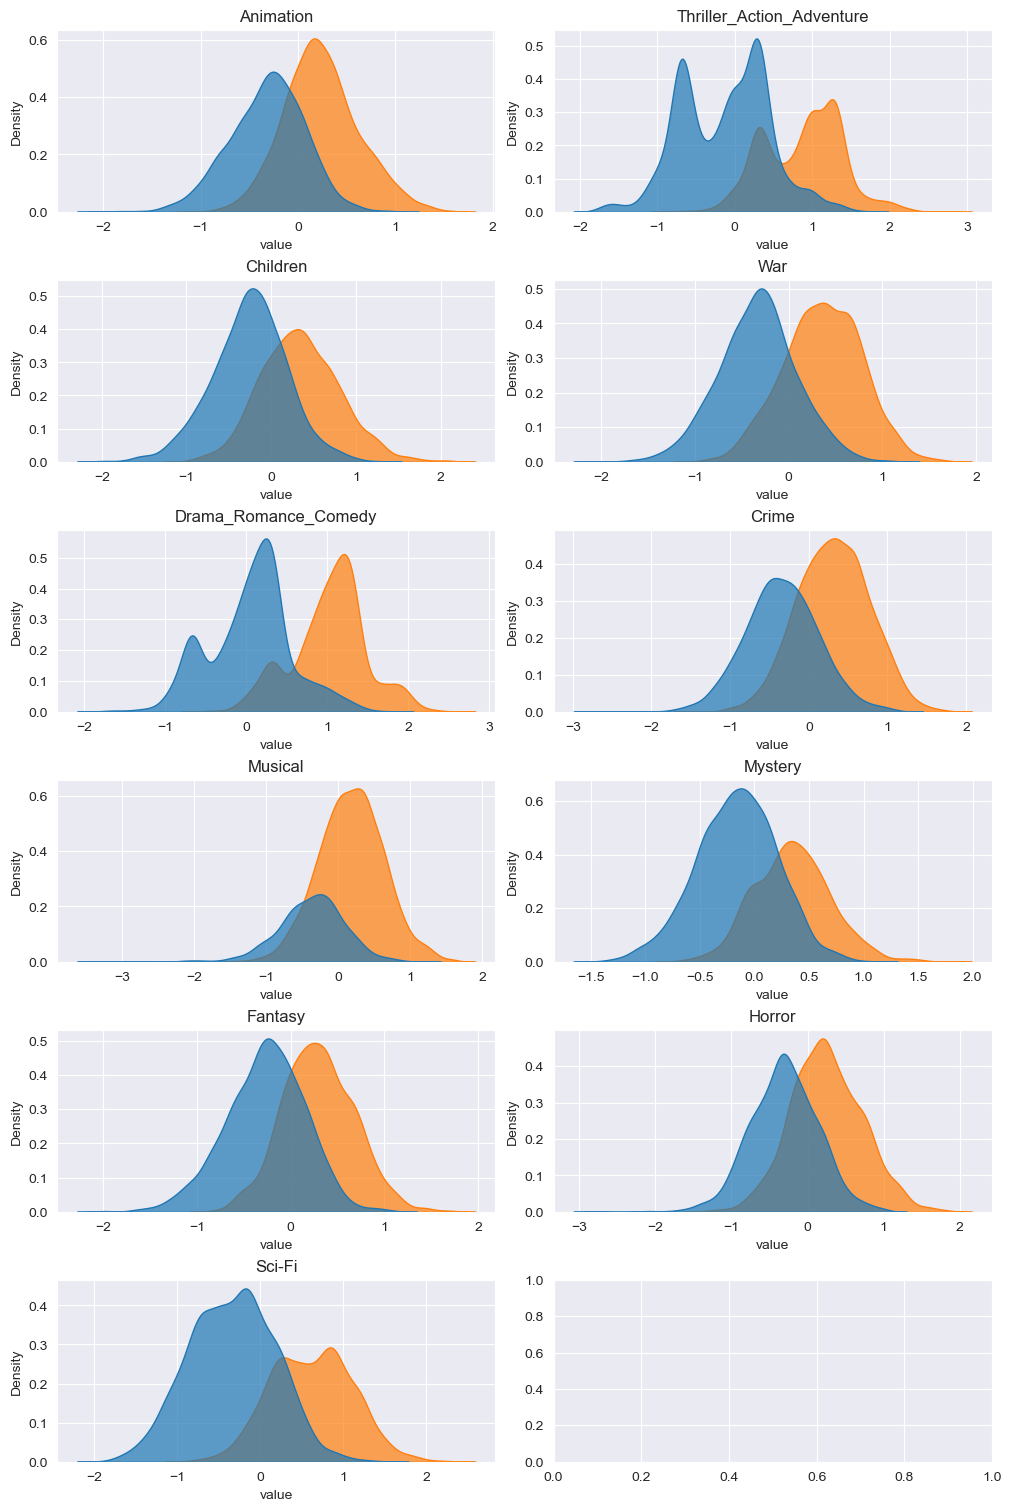

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axs = plt.subplots(6,2, figsize=(10,15), constrained_layout=True)

col_names={0:'Animation',
 1:'Children',
 2:'Drama_Romance_Comedy',
 3:'Musical',
 4:'Fantasy',
 5:'Sci-Fi',
 6:'Thriller_Action_Adventure',
 7:'War',
 8:'Crime',
 9:'Mystery',
 10:'Horror'}

for i in range(11):
    df = pd.DataFrame({"value" : X[:,i],  "category" : np.squeeze(X_binned[:,i])})
    sns.kdeplot(
        data=df,
        x="value",
        hue="category",
        fill=True,          # Optionally fill under the curves
        alpha=0.7  ,
        legend=False,
        ax=axs[i%6, i//6]# Transparency for the fill
    )
    axs[i%6, i//6].set_title(col_names[i])
plt.show()

In [53]:
U = []
for u in X_binned:
    l = []
    for i,r in enumerate(u) :
        if r ==0:
            l.append('hate_'+str(col_names[i]))
        elif r==2:
            l.append('like_'+str(col_names[i]))
        elif r==1:
            l.append('neutral_'+str(col_names[i]))
    U.append(l)
U

[['neutral_Animation',
  'neutral_Children',
  'neutral_Drama_Romance_Comedy',
  'neutral_Musical',
  'neutral_Fantasy',
  'neutral_Sci-Fi',
  'hate_Thriller_Action_Adventure',
  'neutral_War',
  'neutral_Crime',
  'hate_Mystery',
  'neutral_Horror'],
 ['hate_Animation',
  'neutral_Children',
  'hate_Drama_Romance_Comedy',
  'neutral_Musical',
  'neutral_Fantasy',
  'neutral_Sci-Fi',
  'neutral_Thriller_Action_Adventure',
  'neutral_War',
  'neutral_Crime',
  'hate_Mystery',
  'neutral_Horror'],
 ['neutral_Animation',
  'neutral_Children',
  'hate_Drama_Romance_Comedy',
  'hate_Musical',
  'neutral_Fantasy',
  'hate_Sci-Fi',
  'neutral_Thriller_Action_Adventure',
  'neutral_War',
  'neutral_Crime',
  'neutral_Mystery',
  'hate_Horror'],
 ['neutral_Animation',
  'neutral_Children',
  'hate_Drama_Romance_Comedy',
  'neutral_Musical',
  'hate_Fantasy',
  'hate_Sci-Fi',
  'hate_Thriller_Action_Adventure',
  'hate_War',
  'hate_Crime',
  'neutral_Mystery',
  'hate_Horror'],
 ['hate_Animatio

In [54]:
U = []
for u in test_data.log_tensor:
    l = []
    for i,r in enumerate(u) :
        if r ==0:
            l.append('hate_'+str(col_names[i]))
        elif r==2:
            l.append('like_'+str(col_names[i]))
        elif r==1:
            l.append('neutral_'+str(col_names[i]))
    U.append(l)
U

KeyError: 11

import csv
# Write CSV file
with open("test.csv", "wt") as fp:
    writer = csv.writer(fp, delimiter=",")
    writer.writerow(["doc","word","cluster"])  # write header
    for i in range(n):
        for j in range(m*nbb):
            writer.writerow([i,j,X_binned[i,j].astype(int)])


In [55]:
import numpy as np
from skmine.itemsets import SLIM  # Adjust import path if needed

# Using the previous X matrix from the transaction encoder.
# Create and fit the SLIM model.
slim = SLIM(pruning=True)    # Maximum iterations for the solver

# Fit the model to the binary data X.
r = slim.fit_transform(U)
r

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required by SLIM.

In [322]:
r['length'] = r.apply(lambda x : len(x['itemset']), axis=1)

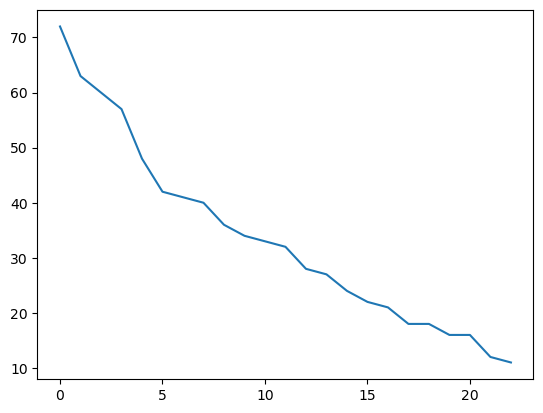

In [317]:
plt.plot(np.arange(len(r[r['length']>3])),r[r['length']>3].sort_values('usage', ascending=False)['usage'])
plt.show()

In [319]:
r[r['length']>5].sort_values('usage', ascending=False)

,itemset,usage,length
12,"[like_Crime, like_Drama_Romance_Comedy, like_Thriller_Action_Adventure, like_War]",72,4
17,"[hate_Drama_Romance_Comedy, hate_Mystery, hate_Sci-Fi, hate_Thriller_Action_Adventure]",63,4
18,"[hate_Drama_Romance_Comedy, hate_Sci-Fi, hate_Thriller_Action_Adventure, hate_War]",60,4
6,"[like_Crime, like_Drama_Romance_Comedy, like_Sci-Fi, like_Thriller_Action_Adventure, like_War]",57,5
2,"[like_Crime, like_Drama_Romance_Comedy, like_Fantasy, like_Horror, like_Sci-Fi, like_Thriller_Action_Adventure, like_War]",48,7
10,"[hate_Drama_Romance_Comedy, hate_Mystery, hate_Sci-Fi, hate_Thriller_Action_Adventure, hate_War]",42,5
20,"[like_Animation, like_Children, like_Fantasy, like_Musical]",41,4
19,"[like_Animation, like_Children, like_Horror, like_Musical]",40,4
14,"[like_Crime, like_Drama_Romance_Comedy, like_Sci-Fi, like_War]",36,4
13,"[like_Crime, like_Drama_Romance_Comedy, like_Sci-Fi, like_Thriller_Action_Adventure]",34,4


In [ ]:
kept_pattern = []
for pattern in r['itemset'] :
    for p2 in r['itemset'] :
        if set(pattern) in (set(p2)) :
            print("yes")

In [ ]:
import skmine
from skmine.itemsets import SLIM

In [ ]:
X_binned

In [ ]:
DD = []
for i in range(u_nb):
    row = []
    for j in range(c_nb * nbb):
        col = j // nbb
        ind = j % nbb
        if(X_binned[i,j] == 1):
            row.append('val-'+str(col)+"_"+str(ind))
    DD.append(row) 

In [ ]:
DD1 = []
for i in range(u_nb):
    row = []
    for j in range(i_nb * nbb):
        col = j // nbb
        ind = j % nbb
        if(X_binned[i,j] == 1):
            row.append(col_names[col]+"_"+str(ind))
    DD1.append(row) 

In [ ]:
D = [
    ['bananas', 'milk'],
    ['milk', 'bananas', 'cookies'],
    ['cookies', 'butter', 'tea'],
    ['tea'],
    ['milk', 'bananas', 'tea'],
]
slim = SLIM(pruning=True)
res = slim.fit_transform(DD)
res2 = slim.fit_transform(DD1)

In [ ]:
# class
xx = -1

res1 = res[res.usage > 150]
print(res1.shape)
y = np.zeros((u_nb, res1.shape[0]))
for p in res1.itemset:
    xx = xx + 1
    print(p)
    v = p #res[0:1].itemset
    for i in range(u_nb):
        val = True
        for j in v:
            #print(j)
            a = j.find("-")
            b = j.find("_")
            col = j[a+1:b]
            #print(col)
            c = j[b+1:]
            #print(c)
            #print(int(col)*nbb)
            if(X_binned[i,int(int(col)*nbb+int(c))] == 0):
                val = False
                #row.append("comp_"+str(col)+"_"+str(ind))
        if(val):
            y[i,xx] = 1

In [ ]:
y

In [ ]:
yy = np.unique(y,axis=0)
yy.shape

yy = y.sort()
y

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(yy, cmap='gray',aspect='auto')

In [ ]:
res2[res2.usage > 150]

res2[res2.usage > 150].to_csv("profils_test.csv")

kmeans = KMeans(n_clusters = 3, random_state = 0, n_init='auto')
kmeans.fit(yy)
kmeans.cluster_centers_

silhouette_avg = []
#data = np.array(x).reshape(-1, 1)
maxc = 15 #np.min([9,n])
#part = np.ones(n)
ss = []
for k in list(range(2,maxc)):
    #print(n, num_clusters)
    kmeans = KMeans(n_clusters = k, random_state = 1, n_init='auto')
    kmeans.fit(yy)
    ss.append(kmeans.inertia_)
    score = silhouette_score(yy, kmeans.labels_)
    silhouette_avg.append(score)

silhouette_avg

ss